<a href="https://colab.research.google.com/github/aradjabova/dsc-capstone-project-v2-online-ds-ft-120919/blob/master/mnist_trial_autoencoder_and_simple_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [0]:
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import os, os.path
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, SeparableConv2D, Activation, GaussianNoise, Input, UpSampling2D
from keras import backend as K
from imblearn.over_sampling import SMOTE
from keras.preprocessing import image
from keras import optimizers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing.image import load_img




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Dataset  

In [0]:
from keras.datasets import mnist

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train= x_train/255
x_test = x_test/255

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
train_list = []

for num in range(len(x_train)):
  train_list.append((x_train[num], y_train[num]))


In [0]:
train_df = pd.DataFrame(train_list, columns=['image', 'label'])

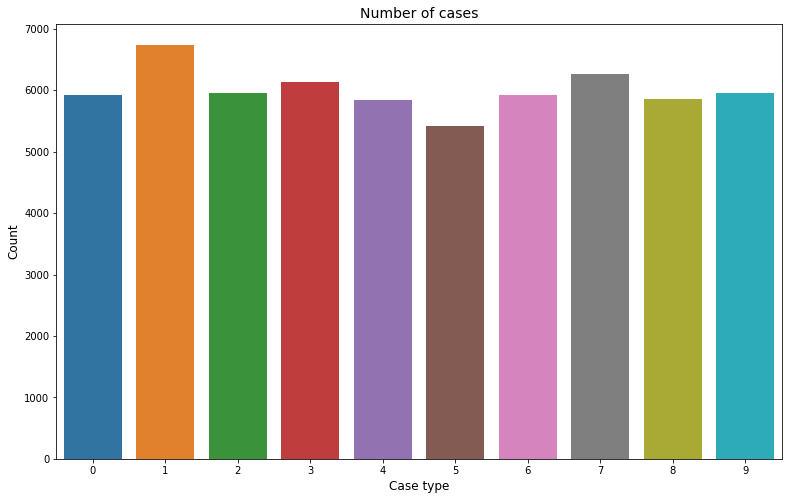

In [0]:
cases_count = train_df['label'].value_counts()

plt.figure(figsize=(13,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

5


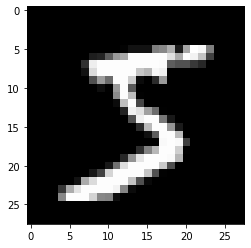

In [0]:
image_index = 0 # You may select anything up to 60,000
print(y_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='gray')

In [0]:
x_train.shape[0]

60000

In [0]:
test_list = []

for num in range(len(x_test)):
  test_list.append((x_test[num], y_test[num]))


In [0]:
test_df = pd.DataFrame(test_list, columns=['image', 'label'])

7


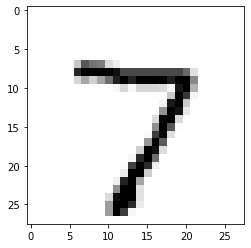

In [0]:
image_index = 0 # You may select anything up to 60,000
print(y_test[image_index]) # The label is 8
plt.imshow(x_test[image_index], cmap='Greys')

In [0]:
train_df.label.value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

In [0]:
x_train.shape

(60000, 28, 28)

In [0]:
x_train2 = x_train.reshape((60000,28*28))

In [0]:
train_df

,image,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9
...,...,...
59995,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",8
59996,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
59997,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5
59998,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",6


# Smoting?


In [0]:
# sm = SMOTE()

In [0]:
# x_smote, y_smote = sm.fit_resample(x_train2, y_train)

In [0]:
# x_smote_reshape = x_smote.reshape(x_smote.shape[0], 28, 28, 1)

# Autoencoder simple

In [0]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train.shape 

(60000, 28, 28, 1)

In [0]:
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [0]:

# input_img = Input(shape=(28,28,1))
# x = Conv2D(32,(3,3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2,2), padding='same')(x)
# x = Conv2D(32,(3,3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2,2), padding='same')(x)
# x = Conv2D(32,(3,3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)



In [0]:
input_img = Input(shape=(28,28,1))

In [0]:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [0]:
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse',
                    metrics=['accuracy','mse'])


In [0]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0   

In [0]:
autoencoder.fit(x_train, x_train, 
                epochs=3,)
                # # batch_size=1000,
                # steps_per_epoch=100,
                # validation_data=(x_test, x_test),
                # validation_steps=100
                # )

Epoch 1/3
60000/60000 [==============================] - 13s 210us/step - loss: 0.0047 - accuracy: 0.8150 - mse: 0.0047
Epoch 2/3
60000/60000 [==============================] - 11s 182us/step - loss: 0.0022 - accuracy: 0.8154 - mse: 0.0022
Epoch 3/3
60000/60000 [==============================] - 11s 180us/step - loss: 0.0018 - accuracy: 0.8155 - mse: 0.0018


In [0]:
autoencoder.evaluate(x_test,x_test)

10000/10000 [==============================] - 1s 85us/step


[0.0015832389002665877, 0.814473569393158, 0.001583239296451211]

In [0]:
x_test[1].shape

(28, 28, 1)

In [0]:
x = x_test[1].reshape(28, 28)
x.shape

(28, 28)

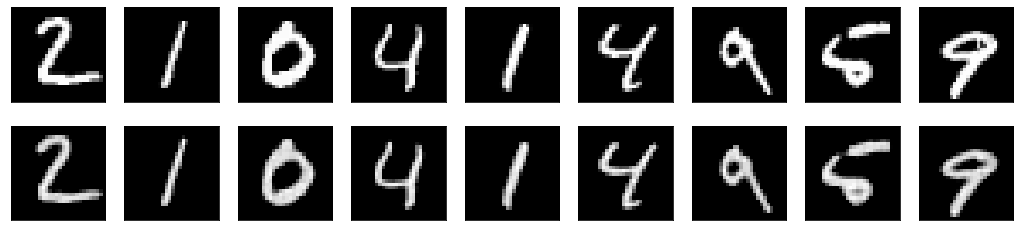

In [0]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Small model

In [0]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [0]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
mod = model.fit(x=x_train,y=y_train, epochs=10, validation_split=.4 )

Train on 36000 samples, validate on 24000 samples
Epoch 1/10
36000/36000 [==============================] - 7s 183us/step - loss: 0.7514 - accuracy: 0.7716 - val_loss: 0.3080 - val_accuracy: 0.9079
Epoch 2/10
36000/36000 [==============================] - 6s 175us/step - loss: 0.2834 - accuracy: 0.9161 - val_loss: 0.2245 - val_accuracy: 0.9311
Epoch 3/10
36000/36000 [==============================] - 6s 176us/step - loss: 0.2104 - accuracy: 0.9369 - val_loss: 0.1768 - val_accuracy: 0.9463
Epoch 4/10
36000/36000 [==============================] - 6s 178us/step - loss: 0.1698 - accuracy: 0.9498 - val_loss: 0.1476 - val_accuracy: 0.9557
Epoch 5/10
36000/36000 [==============================] - 6s 178us/step - loss: 0.1433 - accuracy: 0.9572 - val_loss: 0.1346 - val_accuracy: 0.9599
Epoch 6/10
36000/36000 [==============================] - 6s 176us/step - loss: 0.1264 - accuracy: 0.9611 - val_loss: 0.1244 - val_accuracy: 0.9619
Epoch 7/10
36000/36000 [==============================] - 6s 1

In [0]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 68us/step


[0.08875674017611891, 0.9721999764442444]

In [0]:
# # plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
# for i 
# pred = model.predict(x_test.reshape(1, 28, 28, 1))
# print(pred.argmax())

In [0]:
pred = model.predict(x_test)

In [0]:
accuracy=mod.history['accuracy']
val_acc=mod.history['val_accuracy']
loss=mod.history['loss']
val_loss=mod.history['val_loss']
epochs=list(range(10))


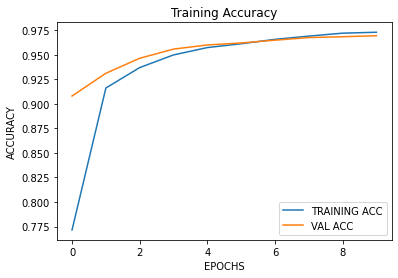

In [0]:
import matplotlib.pyplot as plt
plt.plot(epochs,accuracy)
plt.title('Training Accuracy')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.plot(epochs,val_acc)
plt.legend(['TRAINING ACC','VAL ACC'])
plt.show()

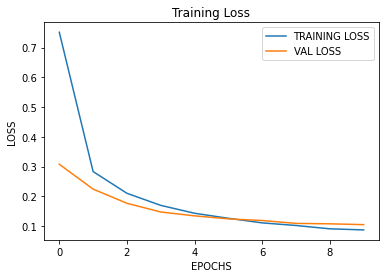

In [0]:
plt.plot(epochs,loss)
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.plot(epochs,val_loss)
plt.legend(['TRAINING LOSS','VAL LOSS'])
plt.title('Training Loss')
plt.show()

In [0]:
pred.shape

(10000, 10)

In [0]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [0]:
pred = np.argmax(pred, axis=1)

In [0]:
print(classification_report(y_test, pred ))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.95      0.96       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



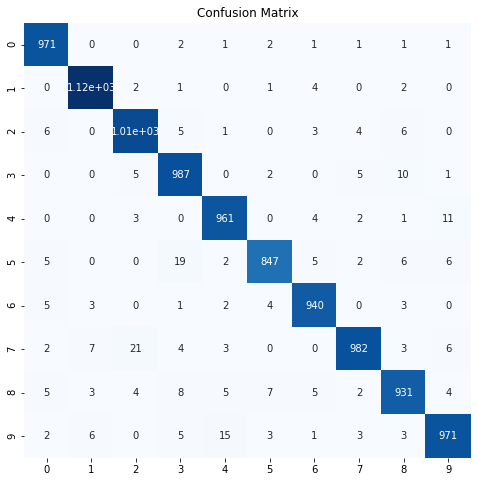

In [0]:
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, cmap="Blues", annot=True, fmt='.3g', cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [0]:
recall_score(y_test, pred, average='micro')

0.9722

# Testing

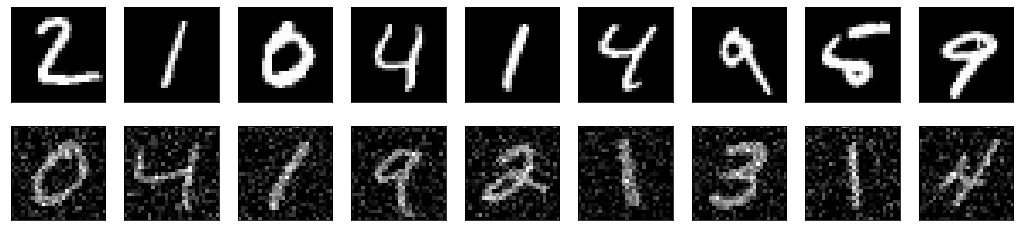

In [0]:
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
# x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

noise_factor = 0.001
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
input_img = Input(shape=(28,28,1))

In [0]:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse',
                    metrics=['accuracy','mse'])

In [0]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 14, 14, 32)        0   

In [0]:
autoencoder.fit(x_train_noisy, x_train,
epochs=10,
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy, x_test),
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 72us/step - loss: 1.7225e-06 - accuracy: 0.8088 - mse: 1.7225e-06 - val_loss: 1.7525e-06 - val_accuracy: 0.8072 - val_mse: 1.7525e-06
Epoch 2/10
60000/60000 [==============================] - 4s 73us/step - loss: 1.7225e-06 - accuracy: 0.8088 - mse: 1.7225e-06 - val_loss: 1.7525e-06 - val_accuracy: 0.8072 - val_mse: 1.7525e-06
Epoch 3/10
60000/60000 [==============================] - 4s 74us/step - loss: 1.7225e-06 - accuracy: 0.8088 - mse: 1.7225e-06 - val_loss: 1.7525e-06 - val_accuracy: 0.8072 - val_mse: 1.7525e-06
Epoch 4/10
60000/60000 [==============================] - 4s 71us/step - loss: 1.7225e-06 - accuracy: 0.8088 - mse: 1.7225e-06 - val_loss: 1.7525e-06 - val_accuracy: 0.8072 - val_mse: 1.7525e-06
Epoch 5/10
60000/60000 [==============================] - 4s 72us/step - loss: 1.7225e-06 - accuracy: 0.8088 - mse: 1.7225e-06 - val_loss: 1.7525e-06 - val_accuracy: 0.80

In [0]:
autoencoder.evaluate(x_test,x_test)

10000/10000 [==============================] - 1s 80us/step


[1.7525275994557886e-06, 0.8072424530982971, 1.7525270550322603e-06]

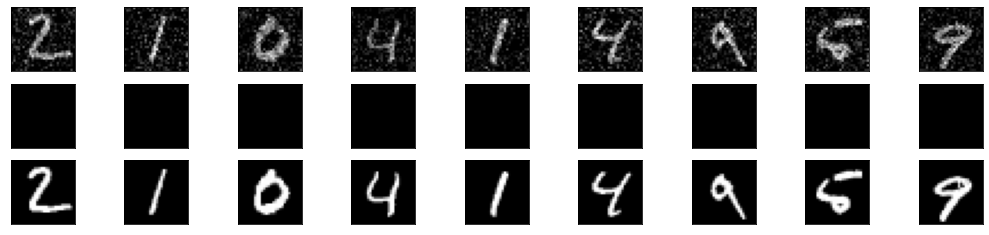

In [0]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + n + 10)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()